Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


### Initialization SparkSession

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using "rate" format. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [3]:
initDF = spark.readStream\
.format('rate')\
.option('rowsPerSecond', 1)\
.load()

### Check if DataFrame is streaming or Not.


In [4]:
initDF.isStreaming

True

### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


### Output

In [5]:
initDF = initDF.withColumn('valuePlusOne', col('value') + lit(1))

In [6]:
initDF.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- value: long (nullable = true)
 |-- valuePlusOne: long (nullable = true)



### Our Second streaming using rate source

In [7]:
writer1 = initDF.writeStream\
.outputMode("append")\
.format("console")

In [8]:
query1 = writer1.start()
query1.awaitTermination()

In [9]:
query1.stop()

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [10]:
df_1 = spark.readStream.format("socket")\
.option("host", "localhost")\
.option("port", 9999)\
.load()

In [11]:
df_1.isStreaming

True

In [13]:
df_1.printSchema()

root
 |-- value: string (nullable = true)



### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [14]:
words = df_1.select(explode(split(df_1.value, " ")).alias("word"))

In [15]:
wordCounts = words.groupBy("word").count()

In [16]:
writer2 = wordCounts.writeStream.format("console").outputMode("update")

In [17]:
query2 = writer2.start()
query2.awaitTermination()

In [18]:
query2.stop()

### Input Sources — File

Schema: Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [134]:
schema = StructType([StructField("Date", StringType(), True),
                     StructField("Open", DoubleType(), True),
                     StructField("High", DoubleType(), True),
                     StructField("Low", DoubleType(), True),
                     StructField("Close", DoubleType(), True),
                     StructField("Volume", DoubleType(), True),
                     StructField("Name", StringType(), True)])

> **Name is already found in csv files. If not, we will create a function using 'input_file_name' function from pyspark.sql.functions**

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [135]:
DF = spark.readStream\
.format("csv")\
.option("maxFilesPerTrigger", 2)\
.option("header", True)\
.option("path", "/users/SAMY/notebook/data/stream")\
.schema(schema)\
.load()

#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [136]:
ResultDF = DF\
.groupBy(col("Name"), year(col("Date")))\
.agg(max("High"))

Can you build same transformation by Sql? 

In [137]:
DF.createOrReplaceTempView("tbl_stock")

In [141]:
result_view = spark.sql("""SELECT year(Date) AS Year, Name, max(High) 
          FROM tbl_stock 
          GROUP BY Name, Year""")

#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [143]:
writer3 = ResultDF.writeStream\
.outputMode("update")\
.format("console")

In [145]:
query3 = writer3.start()
query3.awaitTermination()

In [146]:
query3.stop()

> ### **Reading 2 files per batch**
    
    * Update Mode
    - CVX & CAT, then
    - CSCO & BA, then
    - AMZN & AXP

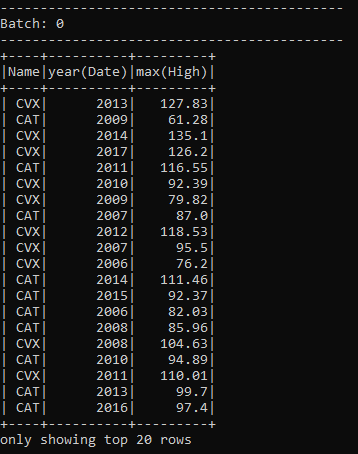

# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [150]:
resultDF2 = DF.select("Name", "Date", "Open", "High", "Low")\
.groupBy(col("Name"), year(col("Date")))\
.agg(avg("High"))\
.withColumn("TimestampCol", current_timestamp())

### Checkpoints

In [151]:
writer4 = resultDF2.writeStream\
.outputMode("complete")\
.option("checkpointLocation", "chkpoint")\
.format("console")

In [153]:
query4 = writer4.start()
query4.awaitTermination()

In [154]:
query4.stop()

> ### **Reading 2 files per batch**
    
    * Complete Mode
    - CVX & CAT, then
    - CVX & CAT & CSCO & BA, then
    - CVX & CAT & CSCO & BA & AMZN & AXP

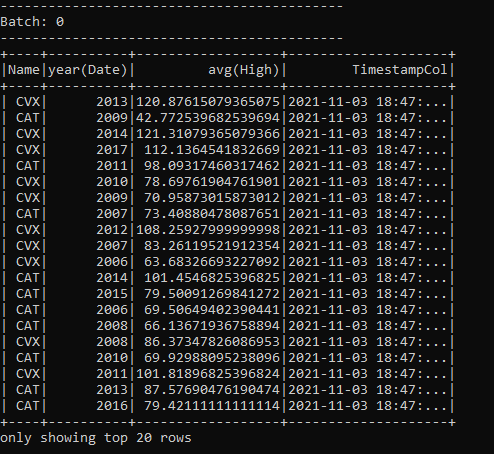

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [1]:
#!pip install graphframes
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
from graphframes import *
sc = SparkContext()

In [2]:
sc.addPyFile('/C:/Spark/spark-3.0.3-bin-hadoop2.7/jars/graphframes-0.8.2-spark3.0-s_2.12.jar/')
spark = SparkSession.builder.appName('graphframes').getOrCreate()

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

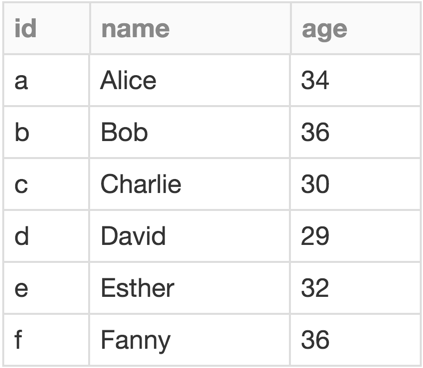

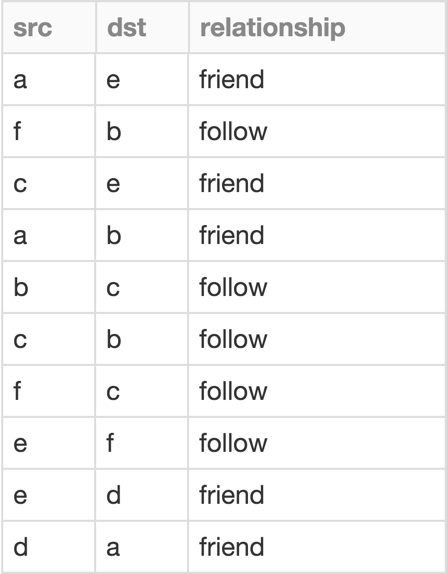

In [3]:
# Vertex DataFrame
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)
], ["id", "name", "age"])
# Edge DataFrame
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])
# Create a GraphFrame


### Create a GraphFrame from vertex and edge DataFrames

In [4]:
g = GraphFrame(v, e)

### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

In [5]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [10]:
edges = g.edges
edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [7]:
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  f|     2|
|  e|     3|
|  d|     2|
|  c|     3|
|  b|     3|
|  a|     3|
+---+------+



In [8]:
g.inDegrees.show()
g.outDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+

+---+---------+
| id|outDegree|
+---+---------+
|  f|        1|
|  e|        2|
|  d|        1|
|  c|        1|
|  b|        1|
|  a|        2|
+---+---------+



## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

In [11]:
copy = edges
from pyspark.sql.functions import udf
@udf("string")
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'
copy.withColumn('undir', to_undir(copy.src, copy.dst))\
.filter('undir == "Keep"').drop('undir').show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  e|  f|      follow|
|  a|  e|      friend|
+---+---+------------+



# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

In [12]:
g.vertices.filter("age > 30").show()
g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()
#g.edges.filter('type == "friend"')

+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alice| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
|  g| Gabby| 60|
+---+------+---+

+---+--------+
| id|inDegree|
+---+--------+
|  c|       2|
|  b|       2|
+---+--------+



GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

In [13]:
sc.setCheckpointDir('graphframes_cps')


Then, the connected components can easily be computed with the connectedComponents-function.


In [182]:
g.connectedComponents().show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
+---+-------+---+------------+



## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph

In [14]:
g.find("(a)-[e]->(b); (b)-[e2]->(a)").show()


+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+

